# BIL 366 Data Mining Final Projesi

## Feyza Becer - Yusuf Özkan

### Amaç - Purpose

* Vaka sayılarının toplu taşımadaki hareketliliğe ve evdeki insan yoğunluğuna etkisi

* The Effect of Covid-19 Cases to Change in Transit and Residential Category in Google Mobility Data in Turkey



In [1529]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import plotly.graph_objs as go
import missingno as msno
import plotly.offline as py
import plotly.express as px
import seaborn as sns

#https://www.google.com/covid19/mobility/

mobility = pd.read_csv('2020_TR_Region_Mobility_Report.csv')
mobility = mobility.rename(columns={'transit_stations_percent_change_from_baseline':'transit_stations',
                                    'residential_percent_change_from_baseline':'residential_per'})

residential = mobility[['residential_per']].copy()
transit = mobility[['transit_stations']].copy()

# https://covid19.saglik.gov.tr/TR-66935/genel-koronavirus-tablosu.html

covid = pd.read_excel("tr_data.xlsx")
#covid = covid.astype(np.uint8,errors="ignore")
covid

,Date,Case
0,2020-03-11,1
1,2020-03-12,0
2,2020-03-13,1
3,2020-03-14,3
4,2020-03-15,13
...,...,...
291,2020-12-27,2806
292,2020-12-28,2816
293,2020-12-29,2783
294,2020-12-30,2612


In [1530]:
mobility.isnull().sum() # missing values

country_region_code                                        0
country_region                                             0
sub_region_1                                             321
sub_region_2                                           25965
metro_area                                            167657
iso_3166_2_code                                       142013
census_fips_code                                      167657
place_id                                                   0
date                                                       0
retail_and_recreation_percent_change_from_baseline     65792
grocery_and_pharmacy_percent_change_from_baseline      61553
parks_percent_change_from_baseline                     72471
transit_stations                                       79934
workplaces_percent_change_from_baseline                 8787
residential_per                                        69006
dtype: int64

In [1531]:
# Toplu taşımadaki hareket datasındaki NaN veriler atıldı düzenlendi ve gruplandı.

transit.index = pd.DatetimeIndex(mobility['date'])
transit = transit.dropna()
transit.index =  pd.to_datetime(transit.index, format = '%Y-%m-%d')
transit.index = transit.index.strftime('%Y-%m-%d')
transit.index =  pd.to_datetime(transit.index, format = '%Y-%m-%d')
transit = transit.reset_index()
transit = transit.groupby(transit.date).mean()

transit_grouped = transit.groupby([transit.index.month]).mean()

transit

,transit_stations
date,
2020-02-15,-11.630872
2020-02-16,-3.076389
2020-02-17,-2.501706
2020-02-18,-2.519164
2020-02-19,-5.498270
...,...
2020-12-27,-74.160142
2020-12-28,-23.770764
2020-12-29,-19.885813


In [1532]:
# Tarih ve günlük yeni vaka sayıları dataframe yapıldı

data = {'date':covid["Date"].values,
        'Cases':covid["Case"].values}

df = pd.DataFrame(data)

# Tarih index kısmına alındı ve df daha düzgün hale getirildi.

df.index =  pd.to_datetime(df["date"], format = '%d.%m.%Y')
df.index = df.index.strftime('%Y-%m-%d')
df.index =  pd.to_datetime(df.index, format = '%Y-%m-%d')
#df.index = pd.DatetimeIndex(df.index).month
#df = df.drop(columns = 'date')
#df.sort_index(inplace=True)

df_grouped = df.groupby([df.index.month]).mean()

df

,date,Cases
date,,
2020-03-11,2020-03-11,1
2020-03-12,2020-03-12,0
2020-03-13,2020-03-13,1
2020-03-14,2020-03-14,3
2020-03-15,2020-03-15,13
...,...,...
2020-12-27,2020-12-27,2806
2020-12-28,2020-12-28,2816
2020-12-29,2020-12-29,2783


In [1533]:
# fig, ax = plt.subplots(figsize=(12,7))

# df.plot(ax=ax, linewidth=4)

fig = px.line(df, x='date', y="Cases")
fig.show()
df = df.drop(columns = 'date')

In [1534]:
# fig, ax = plt.subplots(figsize=(12,7))

# transit.plot(ax=ax, linewidth=4)
transit['date'] = transit.index.copy()
fig = px.line(transit, x='date', y="transit_stations")
fig.show()
transit = transit.drop(columns = 'date')

In [1535]:
merged_df = pd.merge(transit, df, how='inner', on='date')

grouped_df = pd.merge(transit_grouped, df_grouped, how='inner', on='date')
grouped_df['Date'] = grouped_df.index.copy()
merged_df

,transit_stations,Cases
date,,
2020-03-11,-1.694444,1
2020-03-12,3.056338,0
2020-03-13,6.630508,1
2020-03-14,5.500000,3
2020-03-15,-4.069444,13
...,...,...
2020-12-27,-74.160142,2806
2020-12-28,-23.770764,2816
2020-12-29,-19.885813,2783


In [1536]:
merged_df["Date"] = merged_df.index.copy()

In [1537]:
# Cluster analizinde kullanılacak k için optimum değer SSE yöntemiyle tespit edildi.
#merged_df['Date'] = pd.to_numeric(pd.to_datetime(merged_df['Date']))
merged_df = merged_df.drop(columns='Date')
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(merged_df)
    sse.append(km.inertia_)

# Plot sse against k
transit['date'] = transit.index.copy()
fig = px.line(x=list_k, y=sse , labels={
                     "x": "Cluster",
                     "y": "SSE"
                 },
                title="SSE Analysis")
fig.show()
# plt.figure(figsize=(7, 7))
# plt.plot(list_k, sse, 'bx-')
# plt.xlabel(r'Number of clusters *k*')
# plt.ylabel('Sum of squared distance');

In [1538]:
km = KMeans(n_clusters=3,init='k-means++',random_state=0)
#Fitting the input data
km.fit(merged_df)
#predicting the labels of the input data
y = km.predict(merged_df)
y_kmeans= km.fit_predict(merged_df)

#adding the labels to a column named label
merged_df["label"] = y

#The new dataframe with the clustering done

In [1539]:
# Finding Silhouette Score:  < silhouette score is a metric used to calculate the goodness of a clustering technique. >
from sklearn.metrics import silhouette_score

print('Silhoutte score of our model is ' + str(silhouette_score(merged_df, km.labels_)))


Silhoutte score of our model is 0.6376352858475169


In [1540]:
#merged_df["Date"] = merged_df.index.copy()
merged_df

,transit_stations,Cases,label
date,,,
2020-03-11,-1.694444,1,0
2020-03-12,3.056338,0,0
2020-03-13,6.630508,1,0
2020-03-14,5.500000,3,0
2020-03-15,-4.069444,13,0
...,...,...,...
2020-12-27,-74.160142,2806,2
2020-12-28,-23.770764,2816,2
2020-12-29,-19.885813,2783,2


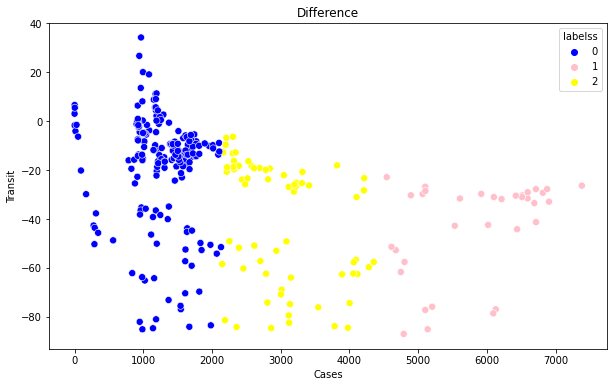

In [1541]:
plt.figure(figsize=(10,6))
merged_df['labelss'] = km.labels_
#print(km.labels_)
sns.scatterplot(x = 'Cases',y = 'transit_stations', hue="labelss",  
                 palette=['blue','pink','yellow'], legend='full',data = merged_df  ,s = 50 )
plt.xlabel('Cases')
plt.ylabel('Transit') 
plt.title('Difference')
plt.show()

In [1542]:
merged_df.isnull().sum()


transit_stations    0
Cases               0
label               0
labelss             0
dtype: int64

In [1543]:
Y = merged_df.iloc[:, [0,1]].values


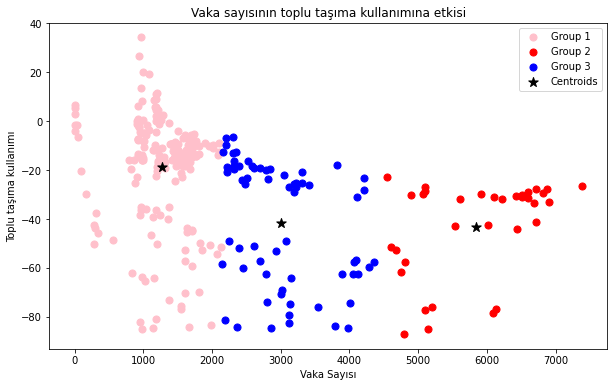

In [1544]:
plt.figure(figsize=(10,6))
plt.scatter(Y[y_kmeans == 0, 1], Y[y_kmeans == 0, 0], s = 50, c = 'pink', label = 'Group 1')
plt.scatter(Y[y_kmeans == 1, 1], Y[y_kmeans == 1, 0], s = 50, c = 'red', label = 'Group 2')
plt.scatter(Y[y_kmeans == 2, 1], Y[y_kmeans == 2, 0], s = 50, c = 'blue', label = 'Group 3')
plt.scatter(km.cluster_centers_[:, 1], km.cluster_centers_[:, 0], s = 100, c = 'black',marker='*', label = 'Centroids')
plt.title('Vaka sayısının toplu taşıma kullanımına etkisi')
plt.xlabel('Vaka Sayısı')
plt.ylabel('Toplu taşıma kullanımı')
plt.legend()
plt.show()

In [1545]:
km.cluster_centers_

array([[ -18.75332048, 1268.96954315],
       [ -43.16712833, 5839.47058824],
       [ -41.64723443, 3003.70769231]])

In [1546]:

merged_df["Date"] = merged_df.index.copy()
merged_df['Date'] = pd.to_numeric(pd.to_datetime(merged_df['Date']))

x = merged_df[['Cases', 'transit_stations']].values
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 0)
kmeans.fit(x)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_


merged_df['labels'] =  labels
trace1 = go.Scatter3d(
    x= merged_df.index,
    y= merged_df['Cases'],
    z= merged_df['transit_stations'],
    mode='markers',
     marker=dict(
        color = labels, 
        size= 8,
        line=dict(
            color= merged_df['labels'],
            width= 16
        ),
        opacity=0.8
     )
)
df = [trace1]

layout = go.Layout(
    title = 'Character vs Gender vs Alive or not',
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0  
    ),
    scene = dict(
            xaxis = dict(title  = 'Date'),
            yaxis = dict(title  = 'Cases'),
            zaxis = dict(title  = 'transit_stations')
        )
)

fig = go.Figure(data = df, layout = layout)
py.iplot(fig)

In [1547]:
km2 = KMeans(n_clusters=4,init='k-means++',random_state=0)
#Fitting the input data
km2.fit(grouped_df)
#predicting the labels of the input data
y = km2.predict(grouped_df)
#adding the labels to a column named label
grouped_df["label"] = y
#The new dataframe with the clustering done
grouped_df

,transit_stations,Cases,Date,label
date,,,,
3,-22.414120,644.333333,3,0
4,-65.299921,3555.766667,4,1
5,-59.173311,1410.903226,5,3
6,-16.975572,1198.800000,6,0
7,-1.602983,998.935484,7,0
8,-4.691757,1266.451613,8,0
9,-12.737263,1617.666667,9,3
10,-10.476184,1826.967742,10,3
11,-25.047507,4183.266667,11,2


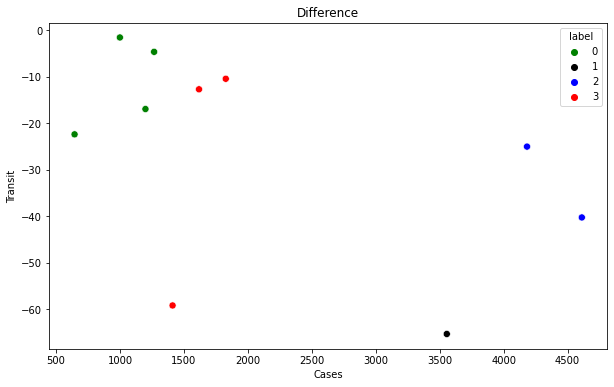

In [1548]:
plt.figure(figsize=(10,6))
sns.scatterplot(x = 'Cases',y = 'transit_stations', hue="label",  
                 palette=['green','black','blue','red'], legend='full',data = grouped_df  ,s = 50 )
plt.xlabel('Cases')
plt.ylabel('Transit') 
plt.title('Difference')
plt.show()

In [1549]:
grouped_df['Date'] = pd.to_numeric(pd.to_datetime(grouped_df['Date']))
x = grouped_df[['Date', 'Cases', 'transit_stations']].values
kmeans = KMeans(n_clusters = 4, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
kmeans.fit(x)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_


grouped_df['labels'] =  labels
trace1 = go.Scatter3d(
    x= grouped_df.index,
    y= grouped_df['Cases'],
    z= grouped_df['transit_stations'],
    mode='markers',
     marker=dict(
        color = grouped_df['labels'], 
        size= 10,
        line=dict(
            color= grouped_df['labels'],
            width= 12
        ),
        opacity=0.8
     )
)
df = [trace1]

layout = go.Layout(
    title = 'Character vs Gender vs Alive or not',
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0  
    ),
    scene = dict(
            xaxis = dict(title  = 'Date'),
            yaxis = dict(title  = 'Cases'),
            zaxis = dict(title  = 'transit_stations')
        )
)

fig = go.Figure(data = df, layout = layout)
py.iplot(fig)

### Evde kalmanın vaka sayısına etkisi

In [1550]:
# Toplu taşımadaki hareket datasındaki NaN veriler atıldı düzenlendi ve gruplandı.
residential = mobility[['residential_per']].copy()

residential.index = pd.DatetimeIndex(mobility['date'])
residential = residential.dropna()
residential.index =  pd.to_datetime(residential.index, format = '%Y-%m-%d')
residential.index = residential.index.strftime('%Y-%m-%d')
residential.index =  pd.to_datetime(residential.index, format = '%Y-%m-%d')
residential = residential.reset_index()
residential = residential.groupby(residential.date).mean()

residential_grouped = residential.groupby([residential.index.month]).mean()
residential

,residential_per
date,
2020-02-15,1.150171
2020-02-16,0.576923
2020-02-17,-1.292537
2020-02-18,-1.875740
2020-02-19,-1.709581
...,...
2020-12-27,22.079422
2020-12-28,10.414835
2020-12-29,10.917582


In [1551]:
residential['date'] = residential.index.copy()
fig = px.line(residential, x='date', y="residential_per")
fig.show()
residential = residential.drop(columns = 'date')

In [1552]:
df2 = pd.DataFrame(data)
df2.index = df2['date']
df2 = df2.drop(columns = 'date')
df2

,Cases
date,
2020-03-11,1
2020-03-12,0
2020-03-13,1
2020-03-14,3
2020-03-15,13
...,...
2020-12-27,2806
2020-12-28,2816
2020-12-29,2783


In [1553]:

merged_df2 = pd.merge(residential, df2, how='inner', on='date')
merged_df2

,residential_per,Cases
date,,
2020-03-11,-2.205357,1
2020-03-12,-2.668657,0
2020-03-13,-0.665663,1
2020-03-14,0.679310,3
2020-03-15,1.194805,13
...,...,...
2020-12-27,22.079422,2806
2020-12-28,10.414835,2816
2020-12-29,10.917582,2783


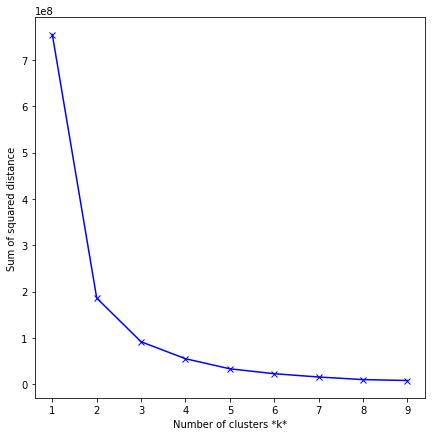

In [1554]:
sse2 = []
list_k2 = list(range(1, 10))

for k in list_k2:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(merged_df2)
    sse2.append(kmeans.inertia_)

# Plot sse against k
plt.figure(figsize=(7, 7))
plt.plot(list_k2, sse2, 'bx-')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

In [1555]:
km2 = KMeans(n_clusters=3,init='k-means++',random_state=0)
#Fitting the input data
km2.fit(merged_df2)
#predicting the labels of the input data
y = km2.predict(merged_df2)
y_kmeans= km2.fit_predict(merged_df2)

#adding the labels to a column named label
merged_df2["label"] = y

#The new dataframe with the clustering done

In [1556]:
labels = km2.labels_

fig = go.Figure(data=go.Scattergl(
    x= merged_df2['Cases'],
    y= merged_df2['residential_per'],
    mode='markers',
    marker=dict(
        color=labels,
        size= 10,
        colorscale='Viridis',
        line_width=1
    )
))

fig.show()

In [1557]:
print('Silhoutte score of our model is ' + str(silhouette_score(merged_df2, km2.labels_)))


Silhoutte score of our model is 0.6387612069321444


In [1558]:
merged_df2.isnull().sum()


residential_per    0
Cases              0
label              0
dtype: int64

In [1559]:
X= merged_df2.iloc[:, [0,1]].values

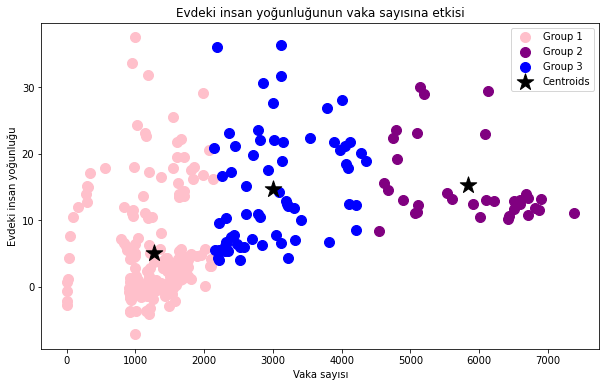

In [1560]:
plt.figure(figsize=(10,6))
plt.scatter(X[y_kmeans == 0, 1], X[y_kmeans == 0, 0], s = 100, c = 'pink', label = 'Group 1')
plt.scatter(X[y_kmeans == 1, 1], X[y_kmeans == 1, 0], s = 100, c = 'purple', label = 'Group 2')
plt.scatter(X[y_kmeans == 2, 1], X[y_kmeans == 2, 0], s = 100, c = 'blue', label = 'Group 3')
plt.scatter(km2.cluster_centers_[:, 1], km2.cluster_centers_[:, 0], s = 300, c = 'black',marker='*', label = 'Centroids')
plt.title('Evdeki insan yoğunluğunun vaka sayısına etkisi')
plt.xlabel('Vaka sayısı')
plt.ylabel('Evdeki insan yoğunluğu')
plt.legend()
plt.show()

In [1561]:

merged_df2["Date"] = merged_df2.index.copy()
merged_df2['Date'] = pd.to_numeric(pd.to_datetime(merged_df2['Date']))

x = merged_df2[['Cases', 'residential_per']].values
kmeans2 = KMeans(n_clusters = 3, init = 'k-means++', random_state = 0)
kmeans2.fit(x)
labels = kmeans2.labels_
centroids = kmeans2.cluster_centers_


merged_df2['labels'] =  labels
trace1 = go.Scatter3d(
    x= merged_df2.index,
    y= merged_df2['Cases'],
    z= merged_df2['residential_per'],
    mode='markers',
     marker=dict(
        color = labels, 
        size= 8,
        line=dict(
            color= merged_df2['labels'],
            width= 16
        ),
        opacity=0.8
     )
)
df2 = [trace1]

layout = go.Layout(
    title = 'Character vs Gender vs Alive or not',
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0  
    ),
    scene = dict(
            xaxis = dict(title  = 'Date'),
            yaxis = dict(title  = 'Cases'),
            zaxis = dict(title  = 'residential_per')
        )
)

fig = go.Figure(data = df2, layout = layout)
py.iplot(fig)

Haftalık Olarak  İnceleme



In [1562]:
# Evdeki insan yoğunluğunun haftalık olarak analiz edilmesi

data_columns = ['Cases', 'residential_per'] 
data_weekly_mean = merged_df2[data_columns].resample('W').mean() # W stands for weekly
data_weekly_mean

,Cases,residential_per
date,,
2020-03-15,3.600000,-0.733112
2020-03-22,174.000000,10.890932
2020-03-29,1140.142857,17.849986
2020-04-05,2550.285714,20.833476
2020-04-12,4269.571429,23.217805
2020-04-19,4192.857143,20.313318
2020-04-26,3403.428571,23.735054
2020-05-03,2273.571429,21.947487
2020-05-10,1801.714286,18.098502


In [1563]:
km_w = KMeans(n_clusters=3,init='k-means++',random_state=0)
#Fitting the input data
km_w.fit(data_weekly_mean)
#predicting the labels of the input data
y_w = km_w.predict(data_weekly_mean)
y_kmeans_w= km_w.fit_predict(data_weekly_mean)

#adding the labels to a column named label
data_weekly_mean["label"] = y_w

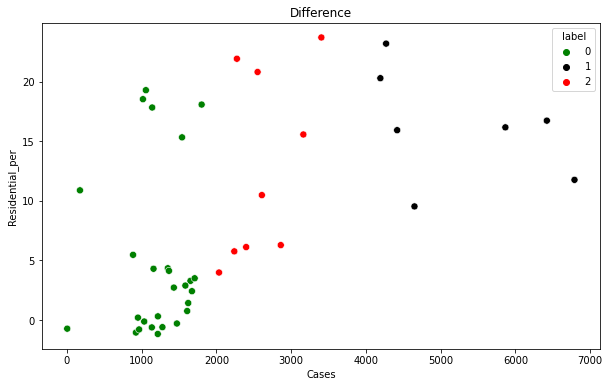

In [1564]:
plt.figure(figsize=(10,6))
sns.scatterplot(x = 'Cases',y = 'residential_per', hue="label",  
                 palette=['green','black','red'], legend='full',data = data_weekly_mean  ,s = 50 )
plt.xlabel('Cases')
plt.ylabel('Residential_per') 
plt.title('Difference')
plt.show()

In [1565]:
labels = km_w.labels_

fig = go.Figure(data=go.Scattergl(
    x= data_weekly_mean['Cases'],
    y= data_weekly_mean['residential_per'],
    mode='markers',
    marker=dict(
        color=labels,
        size= 10,
        colorscale='Viridis',
        line_width=1
    )
))

fig.show()

In [1566]:
Z= data_weekly_mean.iloc[:, [0,1]].values

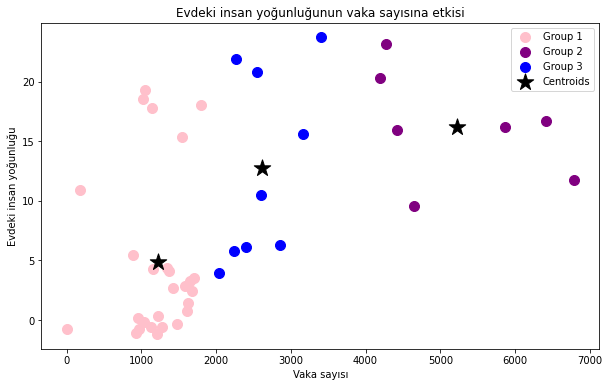

In [1567]:
plt.figure(figsize=(10,6))
plt.scatter(Z[y_kmeans_w == 0, 0], Z[y_kmeans_w == 0, 1], s = 100, c = 'pink', label = 'Group 1')
plt.scatter(Z[y_kmeans_w == 1, 0], Z[y_kmeans_w == 1, 1], s = 100, c = 'purple', label = 'Group 2')
plt.scatter(Z[y_kmeans_w == 2, 0], Z[y_kmeans_w == 2, 1], s = 100, c = 'blue', label = 'Group 3')
plt.scatter(km_w.cluster_centers_[:, 0], km_w.cluster_centers_[:, 1], s = 300, c = 'black',marker='*', label = 'Centroids')
plt.title('Evdeki insan yoğunluğunun vaka sayısına etkisi')
plt.xlabel('Vaka sayısı')
plt.ylabel('Evdeki insan yoğunluğu')
plt.legend()
plt.show()

In [1568]:
# toplu taşımadaki insan sayısının haftalık olarak analiz edilmesi
data_columns_transit = ['Cases', 'transit_stations']
data_weekly_mean2 = merged_df[data_columns_transit].resample('W').mean() # W stands for weekly
data_weekly_mean2

,Cases,transit_stations
date,,
2020-03-15,3.600000,1.884592
2020-03-22,174.000000,-26.936937
2020-03-29,1140.142857,-53.018783
2020-04-05,2550.285714,-62.764514
2020-04-12,4269.571429,-69.331451
2020-04-19,4192.857143,-65.371227
2020-04-26,3403.428571,-69.154720
2020-05-03,2273.571429,-65.165367
2020-05-10,1801.714286,-58.164642


In [1569]:
km2_w = KMeans(n_clusters=3,init='k-means++',random_state=0)
#Fitting the input data
km2_w.fit(data_weekly_mean2)
#predicting the labels of the input data
y_w = km2_w.predict(data_weekly_mean2)
y_kmeans_w= km2_w.fit_predict(data_weekly_mean2)

#adding the labels to a column named label
data_weekly_mean2["label"] = y_w
data_weekly_mean2.isnull().sum()

Cases               0
transit_stations    0
label               0
dtype: int64

In [1570]:
Z= data_weekly_mean2.iloc[:, [0,1]].values

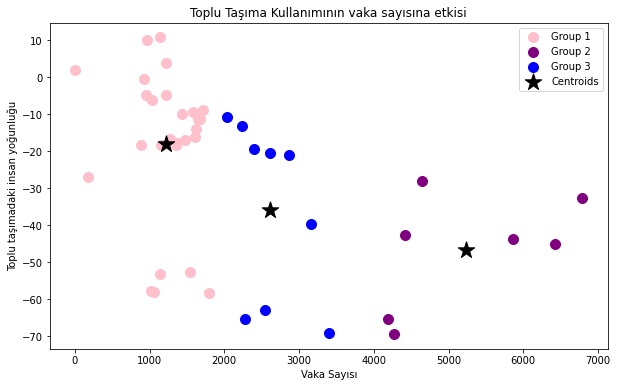

In [1571]:
plt.figure(figsize=(10,6))
plt.scatter(Z[y_kmeans_w == 0, 0], Z[y_kmeans_w == 0, 1], s = 100, c = 'pink', label = 'Group 1')
plt.scatter(Z[y_kmeans_w == 1, 0], Z[y_kmeans_w == 1, 1], s = 100, c = 'purple', label = 'Group 2')
plt.scatter(Z[y_kmeans_w == 2, 0], Z[y_kmeans_w == 2, 1], s = 100, c = 'blue', label = 'Group 3')
plt.scatter(km2_w.cluster_centers_[:, 0], km2_w.cluster_centers_[:, 1], s = 300, c = 'black',marker='*', label = 'Centroids')
plt.title('Toplu Taşıma Kullanımının vaka sayısına etkisi')
plt.xlabel('Vaka Sayısı')
plt.ylabel('Toplu taşımadaki insan yoğunluğu')
plt.legend()
plt.show()

#### Forecasting With Random Forest

In [1572]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble._forest import RandomForestRegressor

from sklearn.metrics import mean_squared_error, r2_score

In [1573]:
data_predict = data_weekly_mean[['Cases','residential_per']]
data_predict

,Cases,residential_per
date,,
2020-03-15,3.600000,-0.733112
2020-03-22,174.000000,10.890932
2020-03-29,1140.142857,17.849986
2020-04-05,2550.285714,20.833476
2020-04-12,4269.571429,23.217805
2020-04-19,4192.857143,20.313318
2020-04-26,3403.428571,23.735054
2020-05-03,2273.571429,21.947487
2020-05-10,1801.714286,18.098502


In [1574]:
### Vaka sayılarına göre evde kalma oranını tahmin etmek istediğimiz için 
### X değerlerine vaka sayılarını y değerlerine evde kalma oranlarını atadık
X = (data_predict['Cases'])
y = (data_predict['residential_per'])

In [1575]:
### Datanın belli bir tarihten öncesini train sonrasını ise test olarak böldük

X_train = X[X.index < "2020-12-10"]
y_train = y[y.index < "2020-12-10"]

X_test = X[X.index >= "2020-12-10"]
y_test = y[y.index >= "2020-12-10"]

In [1576]:
## Random Forest modelini oluşturduk

Model = RandomForestRegressor(n_estimators=100, max_features=1,oob_score=True)
labels = y_train
features = X_train[:, None]

random_forest = Model.fit(features,labels)


## Modeli oluşturup fit ettikten sonra sonuçları görmek için dataframe oluşturduk
X_test_predict=pd.DataFrame(
    random_forest.predict(X_test[:, None])).rename(
    columns={0:'predicted_residential'})
X_train_predict=pd.DataFrame(
    random_forest.predict(X_train[:, None])).rename(
    columns={0:'predicted_residential'})

# görselleştirme ve karşılaştırma yapmak için residential ve vaka veri çerçevelerini birleştirdik
RF_predict = X_train_predict.append(X_test_predict)
RF_predict['date'] = data_predict.index
RF_predict.set_index(['date'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



,predicted_residential
date,
2020-03-15,2.144299
2020-03-22,6.212714
2020-03-29,11.861226
2020-04-05,16.314508
2020-04-12,21.630101
2020-04-19,20.352127
2020-04-26,19.139042
2020-05-03,16.643179
2020-05-10,13.338406


In [1577]:
## Tahmin edilen ve gerçek değerleri aynı dataframede birleştirdik
predict_df = pd.merge(RF_predict, data_predict, how='inner', on='date') 
predict_df.set_index(['date'])

,predicted_residential,Cases,residential_per
date,,,
2020-03-15,2.144299,3.600000,-0.733112
2020-03-22,6.212714,174.000000,10.890932
2020-03-29,11.861226,1140.142857,17.849986
2020-04-05,16.314508,2550.285714,20.833476
2020-04-12,21.630101,4269.571429,23.217805
2020-04-19,20.352127,4192.857143,20.313318
2020-04-26,19.139042,3403.428571,23.735054
2020-05-03,16.643179,2273.571429,21.947487
2020-05-10,13.338406,1801.714286,18.098502


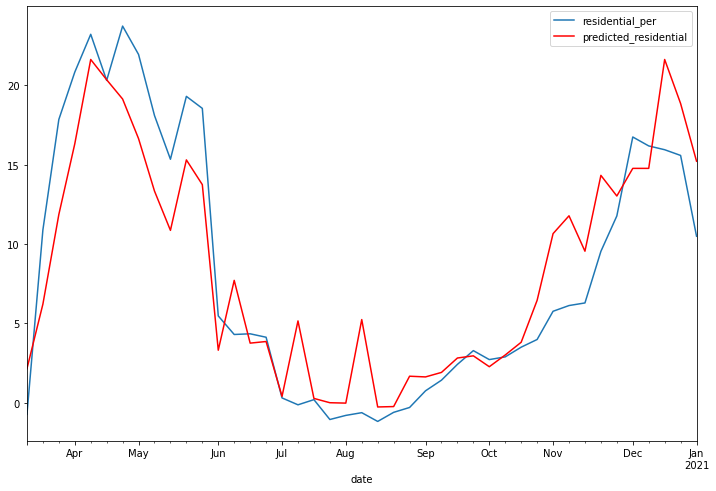

In [1578]:
# Tahmin edilen ve gerçek değerlerin plot gösterimi

plt.rcParams['figure.figsize']=(12,8)

ax = plt.gca()

predict_df.plot(kind='line',x='date',y='residential_per',ax=ax)
predict_df.plot(kind='line',x='date',y='predicted_residential', color='red', ax=ax)

plt.show()

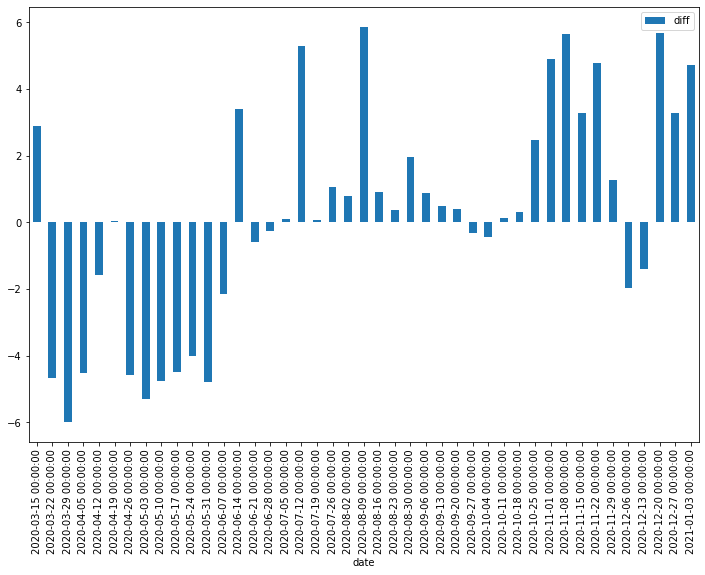

In [1579]:
# Gerçek değerler ve tahmin edilen değerler arasındaki farkın bar plot ile gösterimi

plt.rcParams['figure.figsize']=(12,8)

ax = plt.gca()
predict_df['diff']=predict_df.predicted_residential - predict_df.residential_per
predict_df.plot('date', 'diff',kind='bar',ax=ax)
plt.show()

In [1580]:
pred = X_test_predict['predicted_residential'].values
real = y_test.values

In [1581]:
# Accuracy
errors = abs( pred - real)
print('Average absolute error:', round(np.mean(errors), 2), 'degrees.')
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / pred)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Average absolute error: 3.77 degrees.
Accuracy: 78.93 %.


In [1582]:
# R^2 Score Hesabı
from sklearn.metrics import r2_score
R1Squared = r2_score(y_train[:, None], X_train_predict.values)
print(R1Squared)

0.8431328688544732


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



#### Random Forest Forecasting for Transit Stations

In [1583]:
data_predict2 = data_weekly_mean2[['Cases','transit_stations']]

In [1584]:
X1 = (data_predict2['Cases'])
y1 = (data_predict2['transit_stations'])

In [1585]:
X1_train = X1[X1.index < "2020-12-10"]
y1_train = y1[y1.index < "2020-12-10"]

X1_test = X1[X1.index >= "2020-12-10"]
y1_test = y1[y1.index >= "2020-12-10"]
X1_test.values

array([5865.28571429, 4417.42857143, 3162.57142857, 2607.5       ])

In [1586]:
## Random Forest modelini oluşturduk

Model2 = RandomForestRegressor(n_estimators=100, max_features=1,oob_score=True)
labels2 = y1_train
features2 = X1_train[:, None]

rf = Model.fit(features2,labels2)


## Modeli oluşturup fit ettikten sonra sonuçları görmek için dataframe oluşturduk
X1_test_predict=pd.DataFrame(
    rf.predict(X1_test[:, None])).rename(
    columns={0:'predicted_transit'})
X1_train_predict=pd.DataFrame(
    rf.predict(X1_train[:, None])).rename(
    columns={0:'predicted_transit'})

# görselleştirme ve karşılaştırma yapmak için residential ve vaka veri çerçevelerini birleştirdik
rf_predict = X1_train_predict.append(X1_test_predict)
rf_predict['date'] = data_predict2.index
rf_predict.set_index(['date'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



,predicted_transit
date,
2020-03-15,-9.268259
2020-03-22,-20.220440
2020-03-29,-29.903017
2020-04-05,-50.878234
2020-04-12,-64.213688
2020-04-19,-62.867212
2020-04-26,-61.711311
2020-05-03,-45.649640
2020-05-10,-39.325825


In [1587]:
## Tahmin edilen ve gerçek değerleri aynı dataframede birleştirdik
predict_df2 = pd.merge(rf_predict, data_predict2, how='inner', on='date') 
predict_df2.set_index(['date'])

,predicted_transit,Cases,transit_stations
date,,,
2020-03-15,-9.268259,3.600000,1.884592
2020-03-22,-20.220440,174.000000,-26.936937
2020-03-29,-29.903017,1140.142857,-53.018783
2020-04-05,-50.878234,2550.285714,-62.764514
2020-04-12,-64.213688,4269.571429,-69.331451
2020-04-19,-62.867212,4192.857143,-65.371227
2020-04-26,-61.711311,3403.428571,-69.154720
2020-05-03,-45.649640,2273.571429,-65.165367
2020-05-10,-39.325825,1801.714286,-58.164642


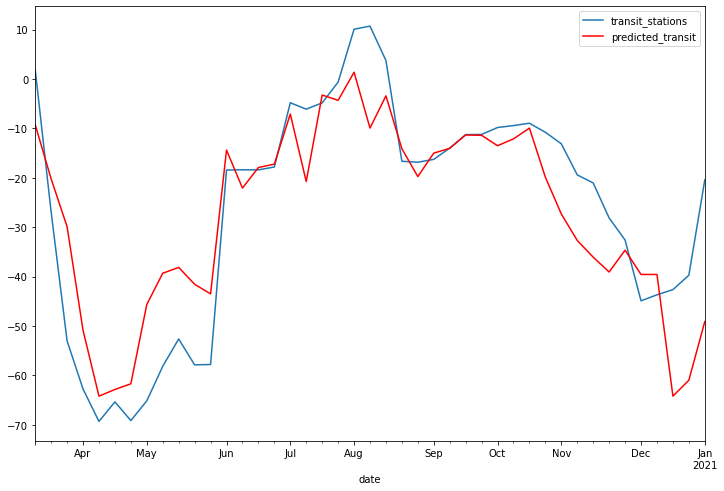

In [1588]:
# Tahmin edilen ve gerçek değerlerin plot gösterimi

plt.rcParams['figure.figsize']=(12,8)

ax = plt.gca()

predict_df2.plot(kind='line',x='date',y='transit_stations',ax=ax)
predict_df2.plot(kind='line',x='date',y='predicted_transit', color='red', ax=ax)

plt.show()

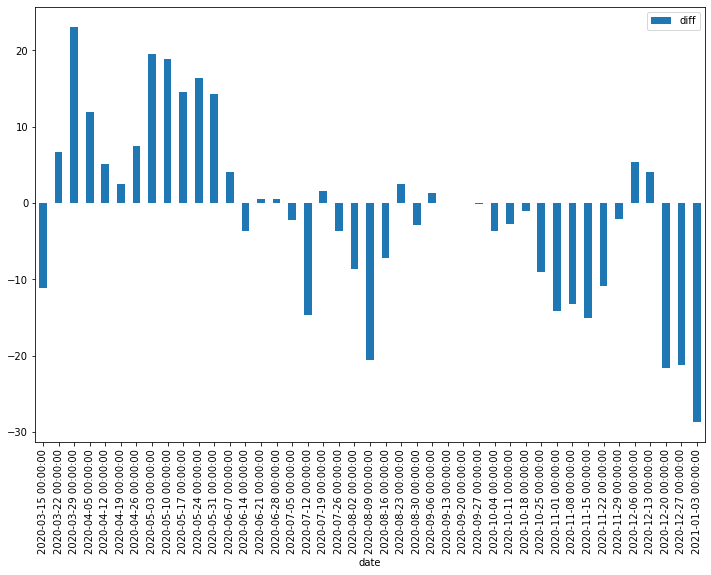

In [1589]:
# Tahmin edilen ve gerçek değerlerin bar plot gösterimi

plt.rcParams['figure.figsize']=(12,8)

ax = plt.gca()
predict_df2['diff']=predict_df2.predicted_transit - predict_df2.transit_stations
predict_df2.plot('date', 'diff',kind='bar',ax=ax)
plt.show()

In [1590]:
pred_ = X1_test_predict['predicted_transit'].values
real_ = y1_test.values

In [1591]:
# Accuracy
errors = abs( pred_ - real_)
print('Average absolute error:', round(np.mean(errors), 2), 'degrees.')
# Calculate mean absolute percentage error (MAPE)
mape = 100 * abs((errors / pred_))
print(mape)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Average absolute error: 18.91 degrees.
[10.40324212 33.58691481 34.8517702  58.41213115]
Accuracy: 65.69 %.


In [1592]:
# R^2 Score Hesabı

from sklearn.metrics import r2_score
RSquared = r2_score(y1_train[:, None], X1_train_predict.values)
print(RSquared)

0.8134139511253623


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



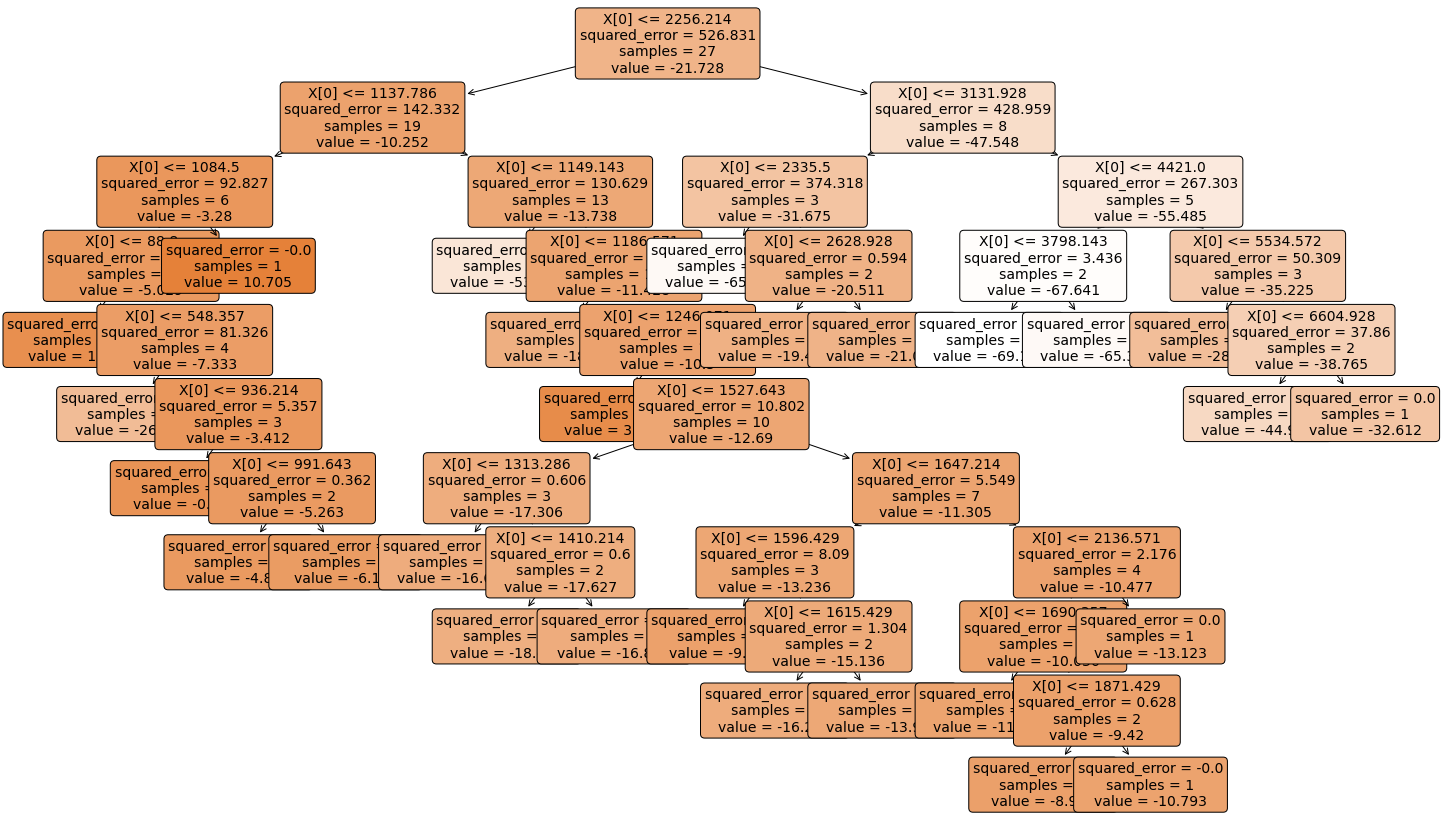

In [1593]:
# Ağacın görselleştirilmesi
import pydot

Tree = rf.estimators_[5]

from sklearn import tree
plt.figure(figsize=(25,15))
tree.plot_tree(Tree,filled=True, 
              rounded=True, 
              fontsize=14);

**SONUÇ**

* Sonuç olarak bu projede; K-Means clustering yöntemi kullanarak vaka sayılarının transit ve residential değerlerine etkisini tarih bazında inceledik. Genel olarak gruplamalarda veriler toplu halde fakat bazı outlier değerler var, bunların da kapanmalardan dolayı olduğunu Sağlık Bakanlığının yayımladığı ve açıkladığı kapanma tarihlerine bakarak gördük ve tespit ettik. 

* Ayrıca yine iki veri için de Random Forest Regression yöntemini kullanarak ileriye dönük tarihlere göre tahmin yaptık. Doğruluk oranının daha çok eğitim verisi kullanılarak yapıldığında daha fazla olacağını düşünüyoruz. Yine de genel olarak tahmin edilen değerler ve gerçek değerler arasında uçuk farkların olmadığını görebiliriz.